<a href="https://colab.research.google.com/github/flaviovdf/aae_bias/blob/main/Semantic_Facct24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for our FACCT 24 submission

## Requirements.

In [1]:
from google.colab import userdata

In [2]:
# change these two links to the real repo url, hidden for reviewers
! git clone {userdata.get('aae_bias_repo')}
! mv aae_bias/data .

fatal: destination path 'aae_bias' already exists and is not an empty directory.
mv: cannot stat 'aae_bias/data': No such file or directory


In [32]:
# notebooks requires coraal and buckeye data in single folder
! cp -r data/buckeye/ data/cb
! cp data/coraal/* data/cb/

In [4]:
! pip install sentence-transformers
! pip install pyaml
! pip install flair
! pip install vaderSentiment
! pip install textblob
! pip install urllib3
! pip install detoxify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.4.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cloud-aiplatform 1.39.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cl

In [5]:
from statsmodels.distributions import ECDF
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

In [6]:
from detoxify import Detoxify

from flair.models import TextClassifier as FlairModel
from flair.data import Sentence as FlairSentence

from textblob import TextBlob

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as Vader

## Scoring functions

The datasets are re-scored with more recent version of methods. Perspective is the exception (requires API).

Also, the data files were originally scored without considering negative polarity.

In [7]:
def text_blob_score(txt):
    return TextBlob(txt).sentiment.polarity

vader = Vader()
def vader_score(txt):
    global vader
    pol = vader.polarity_scores(txt)
    neg = pol["neg"]
    return neg

def detoxify_all(df, unbiased=False):
    if not unbiased:
        model = Detoxify('original', device='cuda')
    else:
        model = Detoxify('unbiased', device='cuda')

    sentences = [x for x in df['text'].values]

    from itertools import islice

    results = []
    def chunker(it, size):
        iterator = iter(it)
        while chunk := list(islice(iterator, size)):
            results.extend(model.predict(chunk)['toxicity'])

    chunker(sentences, 128)
    return pd.Series(results, index=df.index)


def flair_score_all(df):
    flair = FlairModel.load('en-sentiment')
    sentences = [x for x in df['text'].apply(FlairSentence).values]
    flair.predict(sentences)

    return pd.Series(
        list(
            map(lambda s: s.score if s.labels[0]._value[0] == 'P' else -s.score,
                sentences
            )
        ), index=df.index
    )

    return sentences

In [8]:
plt.rcParams['figure.figsize'] = (3.3, 3.3  / 1.65)

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.ymargin'] = 0.1

plt.rcParams['font.family'] = 'serif'

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgrey'
plt.rcParams['grid.linewidth'] = .1

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = .5
plt.rcParams['xtick.minor.visible'] = True

plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = .5
plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['legend.fontsize'] = 10

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 5

In [9]:
plt.style.use('tableau-colorblind10')
plt.ion();

In [10]:
import re

with open('./data/aae_terms_black_talk.yaml') as f:
    aae_t = yaml.safe_load(f)['terms']

aae_t = set(
    map(lambda s: s.
        replace(r"[^\w\d'\s]+", '').
        lower(),
        aae_t
    )
)

def count_aae(txt):
    return sum(
        map(lambda s: s in aae_t, txt.split())
    )

In [33]:
import os

def load_df(fold):
    if os.path.exists(f'{fold}.csv'):
        df = pd.read_csv(f'{fold}.csv').iloc[:, 1:]
        return df
    else:
        files = Path(f'data/{fold}').glob('*')

        dfs = []
        for f in files:
            data = pd.read_csv(f)
            data['file'] = f.stem
            dfs.append(data)

        df = pd.concat(dfs, ignore_index=True)

        df['detoxify_original_score'] = detoxify_all(df, False)
        df['detoxify_unbiased_score'] = detoxify_all(df, True)
        df['textblob_score'] = df['text'].apply(text_blob_score)
        df['vader_score'] = df['text'].apply(vader_score)
        df['flair_score'] = flair_score_all(df)

        df['clean_text'] = (
            df['text'].str.lower().
            str.replace(r"[^\w\d'\s]+", '', regex=True)
        )
        df = df.dropna()

        # df['aae_count'] = df['text'].str.count(r'|'.join(aae_t))
        df['aae_count'] = df['clean_text'].apply(count_aae)
        df = df.sort_index()
        df.to_csv(f'{fold}.csv')
        return df

In [34]:
def cdf_plots(df):
    fig, axes = plt.subplots(1, 6, figsize=(20, 3))
    i = 0
    for scorer in ['textblob_score',
                   'flair_score',
                   'vader_score',
                   'perspective_score',
                   'detoxify_original_score',
                   'detoxify_unbiased_score']:
        aae_cnt = df['aae_count']

        ax = axes[i]

        cm = plt.get_cmap('tab20c').colors
        sub = df[aae_cnt == 0]
        scores = sub[scorer]
        ecdf = ECDF(scores.values)
        ax.plot(ecdf.x, 1-ecdf.y, label='0 AAE Expr.', lw=1.5, color=cm[6])

        color = 15
        if fold == 'twitter':
            ks = [1, 3, 5]
        else:
            ks = [1, 3, 5, 7]
        for k in ks:
            sub = df[aae_cnt >= k]
            scores = sub[scorer]

            ecdf = ECDF(scores.values)
            ax.plot(ecdf.x, 1-ecdf.y, label=f'{k} or more', lw=1.5, color=cm[color])
            color = color - 1

        if i != 0:
            ax.tick_params(left = False)
            ax.yaxis.set_ticklabels([])
        else:
            ax.set(ylabel=r'$P[X \geq x]$')

        if scorer == 'textblob_score':
            ax.set(title='Textblob (L)', xlabel='x - Polarity')
            ax.set(xlim=(-1, 1))
            ax.vlines(0, 0, 1, lw=1, ls='--', color='k', zorder=1)
            ax.text(0.1, 0.5, '➡ Positive Sent.', fontsize=8)
            ax.text(-0.8, 0.5, 'Negative Sent. ⬅', fontsize=8)
            ax.text(-0.98, 0.02, '↙ Majority of uttr\nare negative', fontsize=8)
            ax.text(0.30, 0.90, '↗ Majority of uttr\nare positive', fontsize=8)

        if scorer == 'flair_score':
            ax.set(title='Flair (ML)', xlabel='x - Polarity')
            ax.set(xlim=(-1, 1))
            ax.vlines(0, 0, 1, lw=1, ls='--', color='k', zorder=1)
            ax.text(0.1, 0.5, '➡ Positive Sent.', fontsize=8)
            ax.text(-0.8, 0.5, 'Negative Sent. ⬅', fontsize=8)
            ax.text(-0.98, 0.02, '↙ Majority of uttr\nare negative', fontsize=8)
            ax.text(0.30, 0.90, '↗ Majority of uttr\nare positive', fontsize=8)

        if scorer == 'vader_score':
            ax.legend(loc='center right')
            ax.set(title='Vader (L)', xlabel='x - Neg. Probability')
            ax.set(xlim=(0, 1))
            ax.text(0.22, 0.45, 'Bias more\npresent\nbefore 0.20\nprob.', fontsize=8)
            ax.vlines(0.2, 0, 1, lw=1, ls='--', color='k', zorder=1)
            # ax.text(0.01, 0.02, '↙ Majority of uttr\nare not neg.', fontsize=8)
            ax.text(0.65, 0.90, '↗ Majority of uttr\nare neg.', fontsize=8)

        if scorer == 'detoxify_original_score':
            ax.set(title='Detoxify (ML)', xlabel='x - Toxic Probability')
            ax.set(xlim=(0, 1))
            ax.vlines(0.55, 0, 1, lw=1, ls='--', color='k', zorder=1)
            ax.text(0.56, 0.5, 'Cut-off suggested by: \nMuralikumar et al.\n2023', fontsize=8)
            # ax.text(0.01, 0.30, '↙ Majority of uttr\nhave low scores.', fontsize=8)
            ax.text(0.65, 0.90, '↗ Majority of uttr\nhave high scores.', fontsize=8)

        if scorer == 'detoxify_unbiased_score':
            ax.set(title='Detoxify Unbiased (ML)', xlabel='x - Toxic Probability')
            ax.set(xlim=(0, 1))
            ax.vlines(0.55, 0, 1, lw=1, ls='--', color='k', zorder=1)
            ax.text(0.56, 0.5, 'Cut-off suggested by: \nMuralikumar et al.\n2023', fontsize=8)
            # ax.text(0.01, 0.30, '↙ Majority of uttr\nhave low scores.', fontsize=8)
            ax.text(0.65, 0.90, '↗ Majority of uttr\nhave high scores.', fontsize=8)

        if scorer == 'perspective_score':
            ax.set(title='Perspective (ML)', xlabel='x - Toxic Probability')
            ax.set(xlim=(0, 1))
            ax.vlines(0.55, 0, 1, lw=1, ls='--', color='k', zorder=1)
            ax.text(0.56, 0.5, 'Cut-off suggested by: \nMuralikumar et al.\n2023', fontsize=8)
            # ax.text(0.15, 0.30, '↙ Majority of uttr\nhave low scores.', fontsize=8)
            ax.text(0.65, 0.90, '↗ Majority of uttr\nhave high scores.', fontsize=8)
        ax.set(ylim=(0, 1))
        i += 1
    fig.tight_layout(pad=0)
    # plt.show()
    plt.savefig(f'{fold}.pdf', bbox_inches = 'tight')

## Cumulative Distribution Functions

,text,perspective_score,flair_score,textblob_score,vader_score,detoxify_original_score,detoxify_unbiased_score,detoxify_multilingual_score,has_swearing,file,clean_text,aae_count
0,"text, how long have you lived in dc, approxima...",0.069718,-0.594983,-0.225000,0.0,0.001295,0.000369,0.001610,False,DCB_se1_ag4_m_02_1,text how long have you lived in dc approximate...,1
1,"yeah, can you tell me how dc was when you firs...",0.149567,0.939812,0.145833,0.0,0.003175,0.002287,0.016670,False,DCB_se1_ag4_m_02_1,yeah can you tell me how dc was when you first...,6
2,i was,0.020408,0.936299,0.000000,0.0,0.005765,0.000870,0.000621,False,DCB_se1_ag4_m_02_1,i was,0
3,"i originally lived in the northeast area, whic...",0.349016,0.666808,0.272321,0.0,0.001440,0.042978,0.041946,False,DCB_se1_ag4_m_02_1,i originally lived in the northeast area which...,1
4,you know,0.039942,0.916172,0.000000,0.0,0.002490,0.000538,0.000663,False,DCB_se1_ag4_m_02_1,you know,0


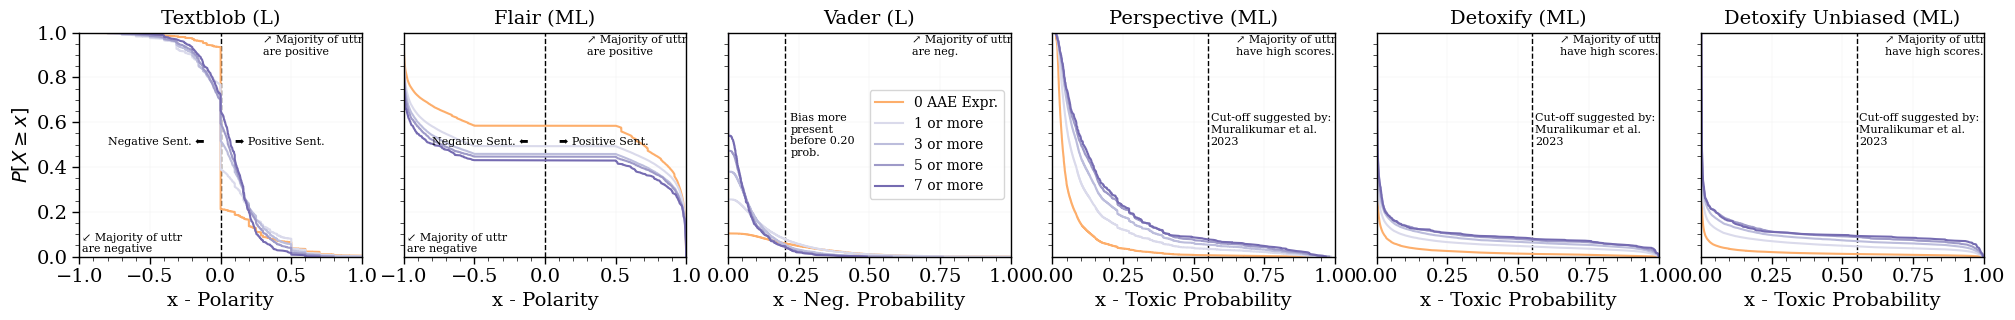

In [35]:
fold = 'cb'
df = load_df(fold)
cdf_plots(df)
df.head()

## Semantic Analysis

In [52]:
from itertools import product
from random import shuffle

def get_extreme_pairs(df):
    cc = []
    for scorer in [
        'textblob_score',
        'flair_score',
        'vader_score',
        'perspective_score',
        'detoxify_original_score',
        'detoxify_unbiased_score'
        ]:
        scores = df[scorer].sort_values().dropna()
        n = int(0.025 * len(df))

        if scorer in {'textblob_score', 'flair_score'}:
            top = scores[:n].index
            bottom = scores[-n:].index
        else:
            top = scores[-n:].index
            bottom = scores[:n].index
        cc.extend(product(top.values, bottom.values))
    cc = list(set(cc))
    shuffle(cc)
    cc = cc[:1000000]
    return list(map(lambda x: x[0], cc)), list(map(lambda x: x[1], cc))

In [53]:
def get_extreme_pairs_utter(df, ep0, ep1):
    u1s = df.loc[ep0].text
    u2s = df.loc[ep1].text
    return u1s, u2s

In [54]:
ep0, ep1 = get_extreme_pairs(df)

In [55]:
len(ep1)

1000000

In [56]:
u1s, u2s = get_extreme_pairs_utter(df, ep0, ep1)

In [57]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

In [58]:
embeddings1 = model.encode(u1s.values, convert_to_tensor=True)
embeddings2 = model.encode(u2s.values, convert_to_tensor=True)

In [59]:
nrm1 = ((embeddings1 ** 2).sum(dim=1) ** 0.5)
nrm2 = ((embeddings2 ** 2).sum(dim=1) ** 0.5)

In [60]:
cosine_scores = (embeddings1 * embeddings2).sum(dim=1) / (nrm1 * nrm2)

In [61]:
import torch
top_sim = torch.where(cosine_scores >= 0.5)[0].cpu()

In [62]:
data = []
ab05 = 0
for i in top_sim:
    top_row = df.loc[ep[i][0]]
    bottom_row = df.loc[ep[i][1]]

    u1 = top_row.text
    u2 = bottom_row.text

    if bottom_row.aae_count - top_row.aae_count < 0:
        for scorer in [
            'textblob_score',
            'flair_score',
            'vader_score',
            'perspective_score',
            'detoxify_original_score',
            'detoxify_unbiased_score']:
            diff = top_row[scorer] - bottom_row[scorer]
            print(scorer, diff)

        print(top_row.aae_count, u1)
        print(bottom_row.aae_count, u2)
        print()
    if bottom_row.aae_count != 0 or top_row.aae_count != 0:
        # if bottom_row.aae_count != top_row.aae_count:
        data.append(bottom_row.aae_count - top_row.aae_count)
data = np.array(data)
print(len(data))
print((data < 0).mean())
print(ab05)

textblob_score -0.3
flair_score -1.873596429824829
vader_score 0.226
perspective_score 0.7491123080000001
detoxify_original_score 0.9747030980652198
detoxify_unbiased_score 0.9790727650397457
6 even the racist ones they love black women, like black women run this shit like ain't too much to say about the black women
0 it was always fun

textblob_score 0.042857142857142844
flair_score 0.20841461420059204
vader_score 0.305
perspective_score 0.7156166810000001
detoxify_original_score 0.9703447342035361
detoxify_unbiased_score 0.9518373410683125
1 yeah, this shit is something else right here
0 um, i think to put things in perspective, my graduating class was twoosix

textblob_score -0.15000000000000002
flair_score 0.03908175230026245
vader_score 0.262
perspective_score 0.6164947780000001
detoxify_original_score 0.8481289746123366
detoxify_unbiased_score 0.9126344758551568
1 you can beat him to death and that's exactly what i do
0 they found a way to still keep themselves relevant

textblob

In [63]:
(data < 0).sum()

314

In [64]:
(data == 0).sum()

57

In [65]:
(data > 0).sum()

130

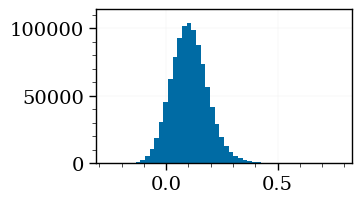

In [67]:
plt.hist(cosine_scores.cpu(), bins=50);